In [17]:
pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 52.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 53.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 22.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import nltk
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [7]:
# Load dataset with correct column names
import pandas as pd

df_train = pd.read_csv("train.csv", header=None, encoding="utf-8")
df_test = pd.read_csv("test.csv", header=None, encoding="utf-8")

print("Train Data Shape:", df_train.shape)
print("Test Data Shape:", df_test.shape)

df_train.head()

# Assign column names
df_train.columns = ['Rating', 'Review']
df_test.columns = ['Rating', 'Review']

# Strip any accidental spaces from column names
#df_train.columns = df_train.columns.str.strip()
#df_test.columns = df_test.columns.str.strip()

# Verify columns exist
print("Train Columns:", df_train.columns)
print("Test Columns:", df_test.columns)

Train Data Shape: (650000, 2)
Test Data Shape: (50000, 2)
Train Columns: Index(['Rating', 'Review'], dtype='object')
Test Columns: Index(['Rating', 'Review'], dtype='object')


In [8]:
# Exclude neutral reviews (3 stars)
df_train = df_train[df_train['Rating'] != 3]
df_test = df_test[df_test['Rating'] != 3]

# Convert ratings to binary sentiment labels
df_train['Sentiment'] = df_train['Rating'].apply(lambda x: 1 if x > 3 else 0)
df_test['Sentiment'] = df_test['Rating'].apply(lambda x: 1 if x > 3 else 0)

# Print the number of rows in the DataFrames
print("Number of rows in the training DataFrame:", len(df_train))
print("Number of rows in the testing DataFrame:", len(df_test))

Number of rows in the training DataFrame: 520000
Number of rows in the testing DataFrame: 40000


In [9]:
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Stopwords and lemmatizer initialization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    text = ''.join([char for char in text if not char.isdigit()])
    words = nltk.word_tokenize(text)
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Drop NaN rows
df_train = df_train.dropna(subset=['Review'])
df_test = df_test.dropna(subset=['Review'])

# Apply preprocessing
df_train['Review'] = df_train['Review'].apply(preprocess_text)
df_test['Review'] = df_test['Review'].apply(preprocess_text)

# Save processed data
df_train.to_csv('processed_train.csv', index=False)
df_test.to_csv('processed_test.csv', index=False)

In [11]:
df_test.head()
df_train.head()

,Rating,Review,Sentiment
0,5,dr goldberg offer everything look general prac...,1
1,2,unfortunately frustration dr goldberg patient ...,0
2,4,going dr goldberg year think one st patient st...,1
3,4,got letter mail last week said dr goldberg mov...,1
4,1,dont know dr goldberg like moving arizona let ...,0


In [12]:
pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 49.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 47.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 18.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
import gensim
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
import gensim.downloader as api

# Load pre-trained Word2Vec embeddings
word_vectors = api.load("word2vec-google-news-300")

[--------------------------------------------------] 1.4% 23.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==------------------------------------------------] 4.6% 75.7/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===-----------------------------------------------] 7.9% 131.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=====---------------------------------------------] 11.1% 184.5/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=======-------------------------------------------] 14.6% 241.9/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=========-----------------------------------------] 18.0% 299.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==========----------------------------------------] 21.5% 356.9/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[============--------------------------------------] 24.9% 413.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==============------------------------------------] 28.2% 469.7/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===============-----------------------------------] 31.6% 525.2/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================---------------------------------] 34.9% 580.5/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===================-------------------------------] 38.2% 635.2/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[====================------------------------------] 41.5% 690.2/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[======================----------------------------] 44.7% 743.9/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=======================---------------------------] 48.0% 797.7/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=========================-------------------------] 51.2% 851.1/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===========================-----------------------] 54.4% 904.3/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[============================----------------------] 57.6% 958.2/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==============================--------------------] 60.9% 1012.9/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[================================------------------] 64.2% 1067.8/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================-----------------] 67.4% 1120.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===================================---------------] 70.6% 1174.2/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[====================================--------------] 73.9% 1229.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[======================================------------] 77.2% 1283.5/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[========================================----------] 80.5% 1338.5/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=========================================---------] 83.8% 1393.8/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===========================================-------] 87.2% 1450.5/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=============================================-----] 90.6% 1506.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==============================================----] 93.9% 1561.5/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[================================================--] 97.2% 1616.5/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [18]:
import pandas as pd
import gensim

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim.downloader as api
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification
import string
import nltk

# Tokenize the cleaned reviews
df_train['Tokenized_Review'] = df_train['Review'].astype(str).apply(word_tokenize)
df_test['Tokenized_Review'] = df_test['Review'].astype(str).apply(word_tokenize)

# Function to convert words into vectors
def review_to_vector(review, model, vector_size=300):
    words = word_tokenize(review)
    word_vectors = [model[word] for word in words if word in model]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(vector_size)

# Save trained Word2Vec model
w2v_model = word_vectors
w2v_model.save("word2vec_yelp.pt")

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
import torch

# Device configuration
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from gensim.models import KeyedVectors
# Load the trained Word2Vec model
model_path = "word2vec_yelp.pt"
w2v_model = KeyedVectors.load(model_path)

# Vectorize reviews
df_train['Vectorized_reviews'] = df_train['Review'].apply(lambda x: review_to_vector(str(x), word_vectors))
df_test['Vectorized_reviews'] = df_test['Review'].apply(lambda x: review_to_vector(str(x), word_vectors))

# Convert to NumPy array
X_train = np.vstack(df_train['Vectorized_reviews'].values)
y_train = torch.tensor(df_train['Sentiment'].values, dtype=torch.float32)

X_test = np.vstack(df_test['Vectorized_reviews'].values)
y_test = torch.tensor(df_test['Sentiment'].values, dtype=torch.float32)

# Custom Dataset Class
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), self.y[idx]

# Create DataLoaders
batch_size = 64
train_dataset = ReviewDataset(X_train, y_train)
test_dataset = ReviewDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [20]:
print(X_train.shape)

(520000, 300)


In [21]:
print(X_test.shape)

(40000, 300)


In [22]:
# Constants
VECTOR_SIZE = 300
HIDDEN_SIZE = 64

# Define the BiLSTM Model
class BiLSTMModel(nn.Module):
    def __init__(self, vector_size, hidden_size, num_classes=1):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(vector_size, hidden_size, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # 
        lstm_out, _ = self.lstm(x)  # 
        hidden = lstm_out[:, -1, :]  # 
        #hidden = self.dropout(hidden)
        output = self.fc(hidden)
        return torch.sigmoid(output).squeeze()


# Device configuration
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate and set up training
model = BiLSTMModel(VECTOR_SIZE, HIDDEN_SIZE).to(device)

# Define the loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [23]:
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=10):
    train_acc, train_prec, train_rec, train_f1 = [], [], [], []
    test_acc, test_prec, test_rec, test_f1 = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        true_labels, predictions = [], []

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()  # 
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

        lr_scheduler.step()

        # Compute Training Metrics
        epoch_train_acc = accuracy_score(true_labels, predictions)
        epoch_train_prec = precision_score(true_labels, predictions)
        epoch_train_rec = recall_score(true_labels, predictions)
        epoch_train_f1 = f1_score(true_labels, predictions)

        train_acc.append(epoch_train_acc)
        train_prec.append(epoch_train_prec)
        train_rec.append(epoch_train_rec)
        train_f1.append(epoch_train_f1)

        # Evaluate on Test Data
        model.eval()
        test_labels, test_predictions = [], []
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                predicted = (outputs > 0.5).float()  # Convert probabilities to binary values

                test_labels.extend(labels.cpu().numpy())
                test_predictions.extend(predicted.cpu().numpy())

        # Compute Test Metrics
        epoch_test_acc = accuracy_score(test_labels, test_predictions)
        epoch_test_prec = precision_score(test_labels, test_predictions)
        epoch_test_rec = recall_score(test_labels, test_predictions)
        epoch_test_f1 = f1_score(test_labels, test_predictions)

        test_acc.append(epoch_test_acc)
        test_prec.append(epoch_test_prec)
        test_rec.append(epoch_test_rec)
        test_f1.append(epoch_test_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Test Acc: {epoch_test_acc:.4f}")

    return train_acc, train_prec, train_rec, train_f1, test_acc, test_prec, test_rec, test_f1

for batch in train_dataloader:
    inputs, labels = batch
    print(f"Input shape before model: {inputs.shape}")  # Should be (batch_size, seq_length, vector_size)
    break


Input shape before model: torch.Size([64, 300])


Epoch 1/10, Loss: 2464.8690, Train Acc: 0.8748, Test Acc: 0.8764
Epoch 2/10, Loss: 2273.8208, Train Acc: 0.8844, Test Acc: 0.8891
Epoch 3/10, Loss: 2210.8600, Train Acc: 0.8875, Test Acc: 0.8887
Epoch 4/10, Loss: 2149.8709, Train Acc: 0.8914, Test Acc: 0.8935
Epoch 5/10, Loss: 2142.5957, Train Acc: 0.8915, Test Acc: 0.8934
Epoch 6/10, Loss: 2136.9959, Train Acc: 0.8918, Test Acc: 0.8936
Epoch 7/10, Loss: 2130.0068, Train Acc: 0.8923, Test Acc: 0.8937
Epoch 8/10, Loss: 2129.2609, Train Acc: 0.8922, Test Acc: 0.8932
Epoch 9/10, Loss: 2128.7355, Train Acc: 0.8922, Test Acc: 0.8941
Epoch 10/10, Loss: 2127.9313, Train Acc: 0.8923, Test Acc: 0.8938
BiLSTM model saved successfully as 'bilstm_model.pt'

Final Training Metrics:
Accuracy: 0.8923
Precision: 0.8919
Recall: 0.8929
F1 Score: 0.8924

Final Testing Metrics:
Accuracy: 0.8938
Precision: 0.8939
Recall: 0.8937
F1 Score: 0.8938


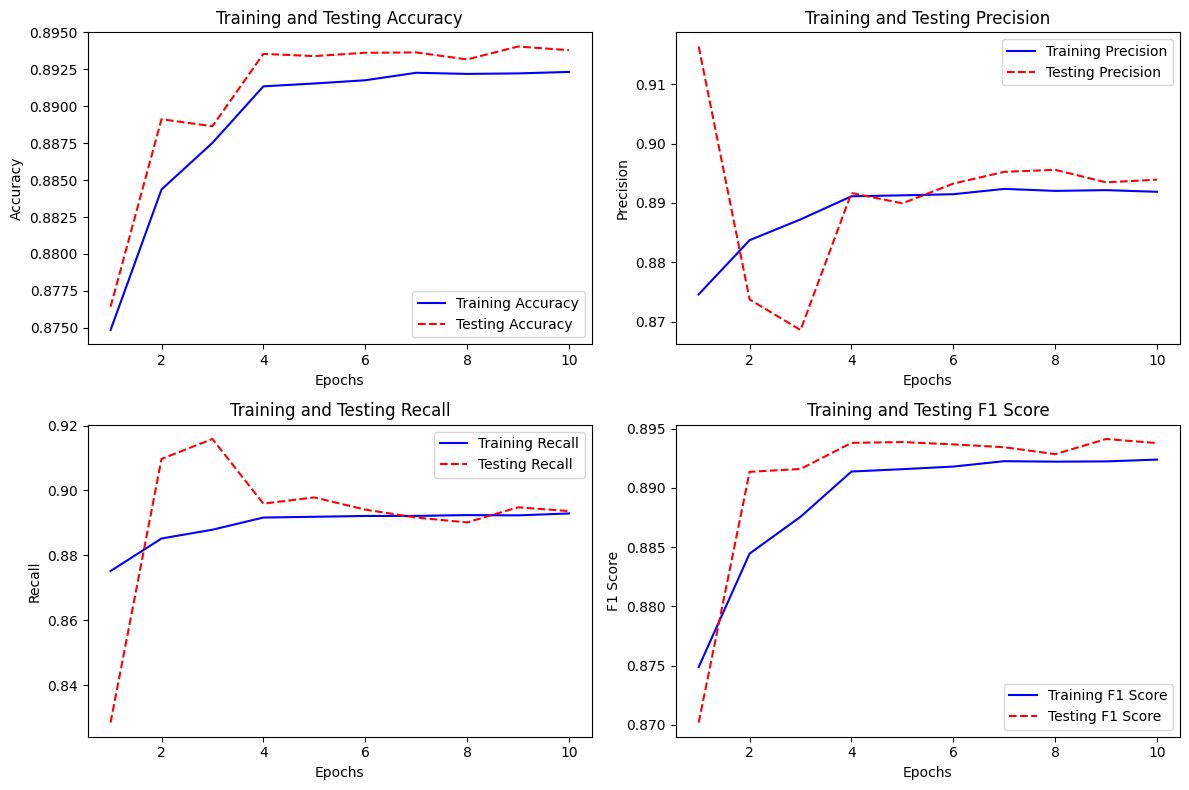

In [24]:
import matplotlib.pyplot as plt

# Call the training function and store metrics
metrics = train_model(model, train_dataloader, test_dataloader, criterion, optimizer)

# Unpack the returned metrics
train_acc, train_prec, train_rec, train_f1, test_acc, test_prec, test_rec, test_f1 = metrics

# Save the trained BiLSTM model
torch.save(model.state_dict(), "bilstm_model.pt")
print("BiLSTM model saved successfully as 'bilstm_model.pt'")

# Print Final Training and Testing Results
print("\nFinal Training Metrics:")
print(f"Accuracy: {train_acc[-1]:.4f}")
print(f"Precision: {train_prec[-1]:.4f}")
print(f"Recall: {train_rec[-1]:.4f}")
print(f"F1 Score: {train_f1[-1]:.4f}\n")

print("Final Testing Metrics:")
print(f"Accuracy: {test_acc[-1]:.4f}")
print(f"Precision: {test_prec[-1]:.4f}")
print(f"Recall: {test_rec[-1]:.4f}")
print(f"F1 Score: {test_f1[-1]:.4f}")


epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 8))

# Accuracy Plot
plt.subplot(2, 2, 1)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, test_acc, 'r--', label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.ylim(0.8, 1)  # Set y-axis to show only from 0 to 0.1

# Precision Plot
plt.subplot(2, 2, 2)
plt.plot(epochs, train_prec, 'b-', label='Training Precision')
plt.plot(epochs, test_prec, 'r--', label='Testing Precision')
plt.title('Training and Testing Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
#plt.ylim(0.8, 1)

# Recall Plot
plt.subplot(2, 2, 3)
plt.plot(epochs, train_rec, 'b-', label='Training Recall')
plt.plot(epochs, test_rec, 'r--', label='Testing Recall')
plt.title('Training and Testing Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
#plt.ylim(0.8, 1)

# F1 Score Plot
plt.subplot(2, 2, 4)
plt.plot(epochs, train_f1, 'b-', label='Training F1 Score')
plt.plot(epochs, test_f1, 'r--', label='Testing F1 Score')
plt.title('Training and Testing F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
#plt.ylim(0.8, 1)

plt.tight_layout()
plt.show()

Model 2 Enhanced BiLSTM

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Constants
VECTOR_SIZE = 300
HIDDEN_SIZE = 128  # Increased hidden size
NUM_LAYERS = 2  # Number of layers in the LSTM
DROPOUT_RATE = 0.2  # Dropout rate


class EnhancedBiLSTMModel(nn.Module):
    def __init__(self, vector_size, hidden_size, num_classes=1, num_layers=2, dropout_rate=0.2):
        super(EnhancedBiLSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(vector_size, hidden_size, num_layers=num_layers,
                            bidirectional=True, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Using hidden_size * 2 because it's bidirectional

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence length dimension (batch_size, 1, vector_size)
        lstm_out, _ = self.lstm(x)
        hidden = lstm_out[:, -1, :]  # Take the output of the last LSTM sequence step
        hidden = self.dropout(hidden)  # Apply dropout
        output = self.fc(hidden)
        return torch.sigmoid(output).squeeze()


# Load data and create dataloaders as per previous setup

# Instantiate and set up training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnhancedBiLSTMModel(VECTOR_SIZE, HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout_rate=DROPOUT_RATE)
model = model.to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

from torch.optim.lr_scheduler import StepLR

# Define the scheduler: Reduces LR by factor of 0.1 every 3 epochs
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)


def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=10):
    train_acc, train_prec, train_rec, train_f1 = [], [], [], []
    test_acc, test_prec, test_rec, test_f1 = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        true_labels, predictions = [], []

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            predicted = outputs > 0.5
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
        lr_scheduler.step()

        # Calculate training metrics
        epoch_train_acc = accuracy_score(true_labels, predictions)
        epoch_train_prec = precision_score(true_labels, predictions)
        epoch_train_rec = recall_score(true_labels, predictions)
        epoch_train_f1 = f1_score(true_labels, predictions)

        train_acc.append(epoch_train_acc)
        train_prec.append(epoch_train_prec)
        train_rec.append(epoch_train_rec)
        train_f1.append(epoch_train_f1)

        # Evaluate on test data
        model.eval()
        test_labels, test_predictions = [], []
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                predicted = outputs > 0.5

                test_labels.extend(labels.cpu().numpy())
                test_predictions.extend(predicted.cpu().numpy())

        # Calculate test metrics
        epoch_test_acc = accuracy_score(test_labels, test_predictions)
        epoch_test_prec = precision_score(test_labels, test_predictions)
        epoch_test_rec = recall_score(test_labels, test_predictions)
        epoch_test_f1 = f1_score(test_labels, test_predictions)

        test_acc.append(epoch_test_acc)
        test_prec.append(epoch_test_prec)
        test_rec.append(epoch_test_rec)
        test_f1.append(epoch_test_f1)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Loss: {total_loss / len(train_dataloader):.4f}, '
              f'Train Acc: {epoch_train_acc:.4f}, '
              f'Test Acc: {epoch_test_acc:.4f}')

    return train_acc, train_prec, train_rec, train_f1, test_acc, test_prec, test_rec, test_f1

Epoch 1/10, Loss: 0.3266, Train Acc: 0.8641, Test Acc: 0.8809
Epoch 2/10, Loss: 0.2925, Train Acc: 0.8791, Test Acc: 0.8827
Epoch 3/10, Loss: 0.2874, Train Acc: 0.8806, Test Acc: 0.8834
Epoch 4/10, Loss: 0.2839, Train Acc: 0.8821, Test Acc: 0.8841
Epoch 5/10, Loss: 0.2834, Train Acc: 0.8821, Test Acc: 0.8842
Epoch 6/10, Loss: 0.2831, Train Acc: 0.8822, Test Acc: 0.8841
Epoch 7/10, Loss: 0.2827, Train Acc: 0.8822, Test Acc: 0.8842
Epoch 8/10, Loss: 0.2826, Train Acc: 0.8822, Test Acc: 0.8842
Epoch 9/10, Loss: 0.2825, Train Acc: 0.8822, Test Acc: 0.8843
Epoch 10/10, Loss: 0.2825, Train Acc: 0.8824, Test Acc: 0.8842
✅ Model saved successfully as 'enhanced_bilstm.pt'


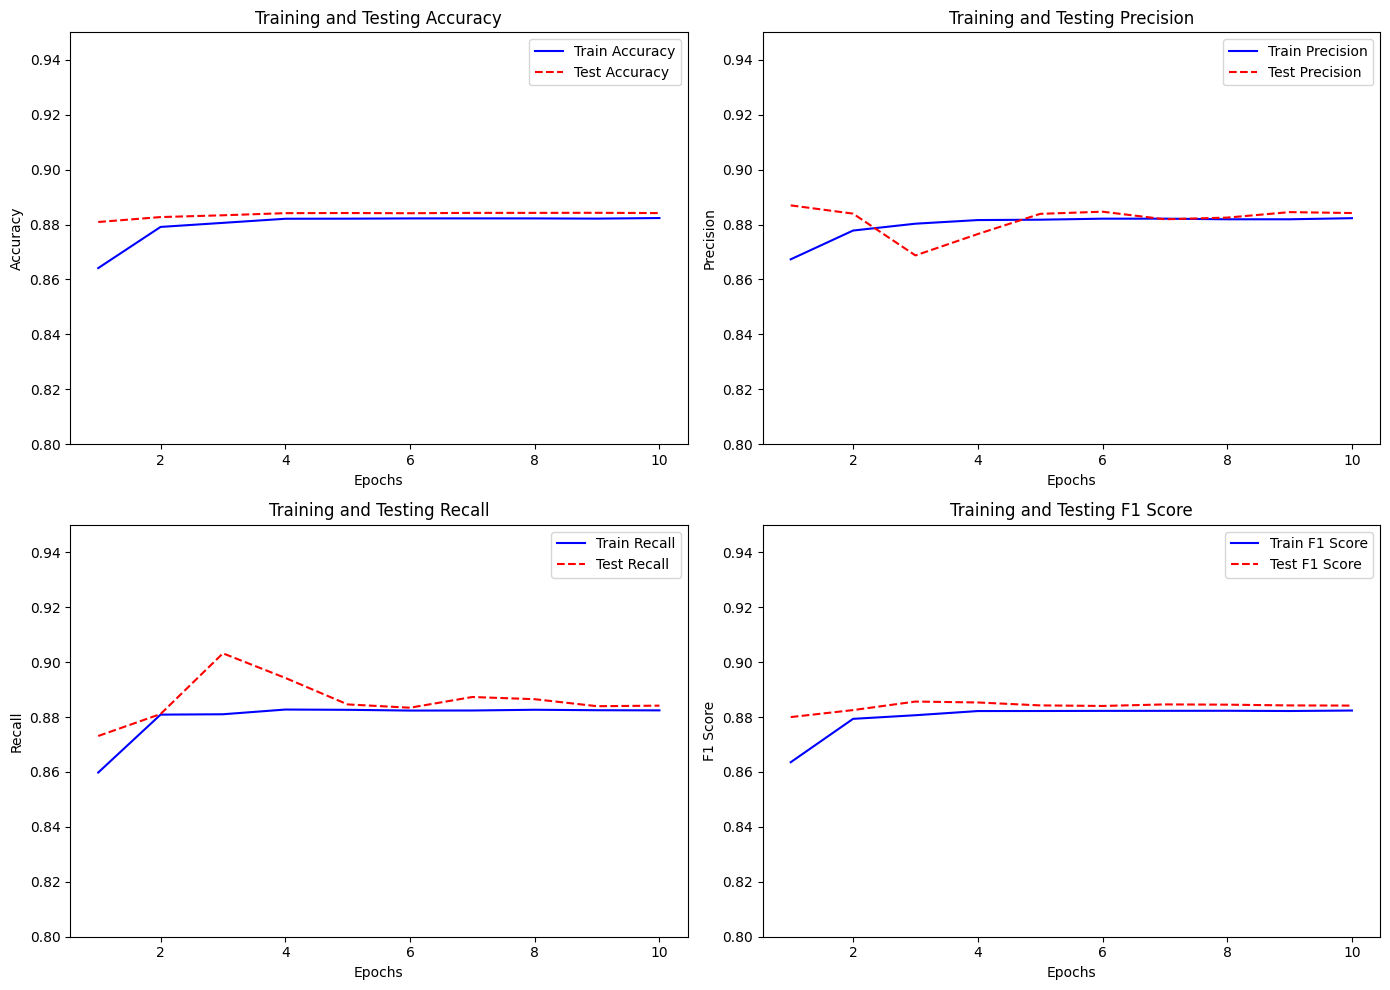

In [26]:
# Train the model and get metrics
metrics = train_model(model, train_dataloader, test_dataloader, criterion, optimizer)

# Unpack the returned metrics properly
enhanced_train_acc, enhanced_train_prec, enhanced_train_rec, enhanced_train_f1, \
enhanced_test_acc, enhanced_test_prec, enhanced_test_rec, enhanced_test_f1 = metrics

# Save the trained Enhanced BiLSTM model
torch.save(model.state_dict(), "enhanced_bilstm.pt")
print("✅ Model saved successfully as 'enhanced_bilstm.pt'")

# Define epochs range
epochs = range(1, len(enhanced_train_acc) + 1)

plt.figure(figsize=(14, 10))

# Plot Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, enhanced_train_acc, 'b-', label='Train Accuracy')
plt.plot(epochs, enhanced_test_acc, 'r--', label='Test Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0.8, 0.95)

# Plot Precision
plt.subplot(2, 2, 2)
plt.plot(epochs, enhanced_train_prec, 'b-', label='Train Precision')
plt.plot(epochs, enhanced_test_prec, 'r--', label='Test Precision')
plt.title('Training and Testing Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.ylim(0.8, 0.95)

# Plot Recall
plt.subplot(2, 2, 3)
plt.plot(epochs, enhanced_train_rec, 'b-', label='Train Recall')
plt.plot(epochs, enhanced_test_rec, 'r--', label='Test Recall')
plt.title('Training and Testing Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.ylim(0.8, 0.95)

# Plot F1 Score
plt.subplot(2, 2, 4)
plt.plot(epochs, enhanced_train_f1, 'b-', label='Train F1 Score')
plt.plot(epochs, enhanced_test_f1, 'r--', label='Test F1 Score')
plt.title('Training and Testing F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.ylim(0.8, 0.95)

plt.tight_layout()
plt.show()

Model-3-HAN

In [27]:
!pip install torch==2.0.1 torchtext==0.15.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 20.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 47.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 51.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 13.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 29.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 43.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 35.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 28.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from torchtext.vocab import GloVe
from torch.nn.utils.rnn import pad_sequence
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

# Enable fast GPU processing
torch.backends.cudnn.benchmark = True

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Preprocessed Dataset
#df_train = pd.read_csv('processed_train.csv')
#df_test = pd.read_csv('processed_test.csv')

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

#nltk.download('punkt')  # Ensure required NLTK data is downloaded


In [29]:
#import nltk
#from nltk.tokenize import sent_tokenize, word_tokenize

#nltk.download('punkt_tab')  # Ensure required NLTK data is downloaded

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [37]:
# Convert Reviews to Word2Vec Indexes (No Change in Your Code)
#from gensim.models import KeyedVectors

#model_path = "word2vec_yelp.pt"
#w2v_model = KeyedVectors.load(model_path)

def review_to_vector(review, model, vector_size=300):
    words = word_tokenize(str(review))
    word_vectors = [model[word] for word in words if word in model]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(vector_size)

df_train["Vectorized_reviews"] = df_train["Review"].apply(lambda x: review_to_vector(str(x), w2v_model))
df_test["Vectorized_reviews"] = df_test["Review"].apply(lambda x: review_to_vector(str(x), w2v_model))

# Convert to NumPy Array
X_train = np.vstack(df_train["Vectorized_reviews"].values)
y_train = torch.tensor(df_train["Sentiment"].values, dtype=torch.float32)

X_test = np.vstack(df_test["Vectorized_reviews"].values)
y_test = torch.tensor(df_test["Sentiment"].values, dtype=torch.float32)

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Assuming X_train, y_train, X_test, y_test are already defined and device is set

# Custom Dataset Class
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  # Tensor of vectorized reviews
        self.y = y  # Sentiment labels

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), self.y[idx]

# Create DataLoaders
batch_size = 64
train_dataset = ReviewDataset(X_train, y_train)
test_dataset = ReviewDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [39]:
# Define Attention Mechanism
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn_weights = nn.Linear(hidden_dim * 2, 1)

    def forward(self, lstm_output):
        attn_scores = self.attn_weights(lstm_output).squeeze(-1)  # Compute attention scores
        attn_weights = torch.softmax(attn_scores, dim=1)  # Normalize scores
        context_vector = torch.sum(attn_weights.unsqueeze(-1) * lstm_output, dim=1)  # Weighted sum
        return context_vector

# Define HAN Model Using Word2Vec with Dropout
class HierarchicalAttentionNetwork(nn.Module):
    def __init__(self, vector_size, hidden_size, dropout_prob=0.5):
        super(HierarchicalAttentionNetwork, self).__init__()

        # Word-Level BiLSTM + Attention
        self.word_lstm = nn.LSTM(vector_size, hidden_size, bidirectional=True, batch_first=True)
        self.word_attention = Attention(hidden_size)

        # Dropout layer to improve generalization
        self.dropout = nn.Dropout(dropout_prob)

        # Final Classification Layer
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        # Input shape: (batch_size, embedding_size)
        x = x.unsqueeze(1)  # Expand to (batch_size, 1, embedding_size)

        # Apply Word-Level BiLSTM
        word_lstm_out, _ = self.word_lstm(x)
        word_context = self.word_attention(word_lstm_out)

        # Apply dropout before final classification
        word_context = self.dropout(word_context)
        output = self.fc(word_context)
        return torch.sigmoid(output).squeeze()

# Initialize HAN Model
vector_size = 300  # Word2Vec Dimension
hidden_size = 128
model = HierarchicalAttentionNetwork(vector_size, hidden_size, dropout_prob=0.2).to(device)


# Define Loss, Optimizer, and Learning Rate Scheduler
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)

# Prepare lists to store metrics
epochs = 20  # Increased epochs for better convergence
train_acc_history = []
train_prec_history = []
train_rec_history = []
train_f1_history = []

test_acc_history = []
test_prec_history = []
test_rec_history = []
test_f1_history = []

# Training Loop with per-epoch evaluation
for epoch in range(epochs):
    model.train()
    total_loss = 0
    train_true_labels, train_predictions = [], []

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.round(outputs)
        train_true_labels.extend(labels.cpu().numpy())
        train_predictions.extend(preds.detach().cpu().numpy())

    # Compute training metrics for the epoch
    train_acc = accuracy_score(train_true_labels, train_predictions)
    train_prec = precision_score(train_true_labels, train_predictions)
    train_rec = recall_score(train_true_labels, train_predictions)
    train_f1 = f1_score(train_true_labels, train_predictions)

    train_acc_history.append(train_acc)
    train_prec_history.append(train_prec)
    train_rec_history.append(train_rec)
    train_f1_history.append(train_f1)

    # Evaluate on the test set after each epoch
    model.eval()
    test_true_labels, test_predictions = [], []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.round(outputs)
            test_true_labels.extend(labels.cpu().numpy())
            test_predictions.extend(preds.detach().cpu().numpy())

    test_acc = accuracy_score(test_true_labels, test_predictions)
    test_prec = precision_score(test_true_labels, test_predictions)
    test_rec = recall_score(test_true_labels, test_predictions)
    test_f1 = f1_score(test_true_labels, test_predictions)

    test_acc_history.append(test_acc)
    test_prec_history.append(test_prec)
    test_rec_history.append(test_rec)
    test_f1_history.append(test_f1)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f},Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    scheduler.step()

Epoch 1/20, Loss: 2868.8283,Train Acc: 0.8550, Test Acc: 0.8782
Epoch 2/20, Loss: 2480.5099,Train Acc: 0.8780, Test Acc: 0.8798
Epoch 3/20, Loss: 2444.6696,Train Acc: 0.8794, Test Acc: 0.8817
Epoch 4/20, Loss: 2412.8451,Train Acc: 0.8802, Test Acc: 0.8826
Epoch 5/20, Loss: 2388.8932,Train Acc: 0.8805, Test Acc: 0.8818
Epoch 6/20, Loss: 2371.0877,Train Acc: 0.8811, Test Acc: 0.8837
Epoch 7/20, Loss: 2356.4860,Train Acc: 0.8815, Test Acc: 0.8838
Epoch 8/20, Loss: 2346.4388,Train Acc: 0.8820, Test Acc: 0.8849
Epoch 9/20, Loss: 2339.0444,Train Acc: 0.8824, Test Acc: 0.8847
Epoch 10/20, Loss: 2332.3955,Train Acc: 0.8827, Test Acc: 0.8850
Epoch 11/20, Loss: 2326.1004,Train Acc: 0.8829, Test Acc: 0.8851
Epoch 12/20, Loss: 2321.2768,Train Acc: 0.8831, Test Acc: 0.8853
Epoch 13/20, Loss: 2317.0825,Train Acc: 0.8832, Test Acc: 0.8856
Epoch 14/20, Loss: 2313.3788,Train Acc: 0.8836, Test Acc: 0.8858
Epoch 15/20, Loss: 2309.3602,Train Acc: 0.8836, Test Acc: 0.8861
Epoch 16/20, Loss: 2306.8173,Train

Model saved successfully as 'han_model.pt'


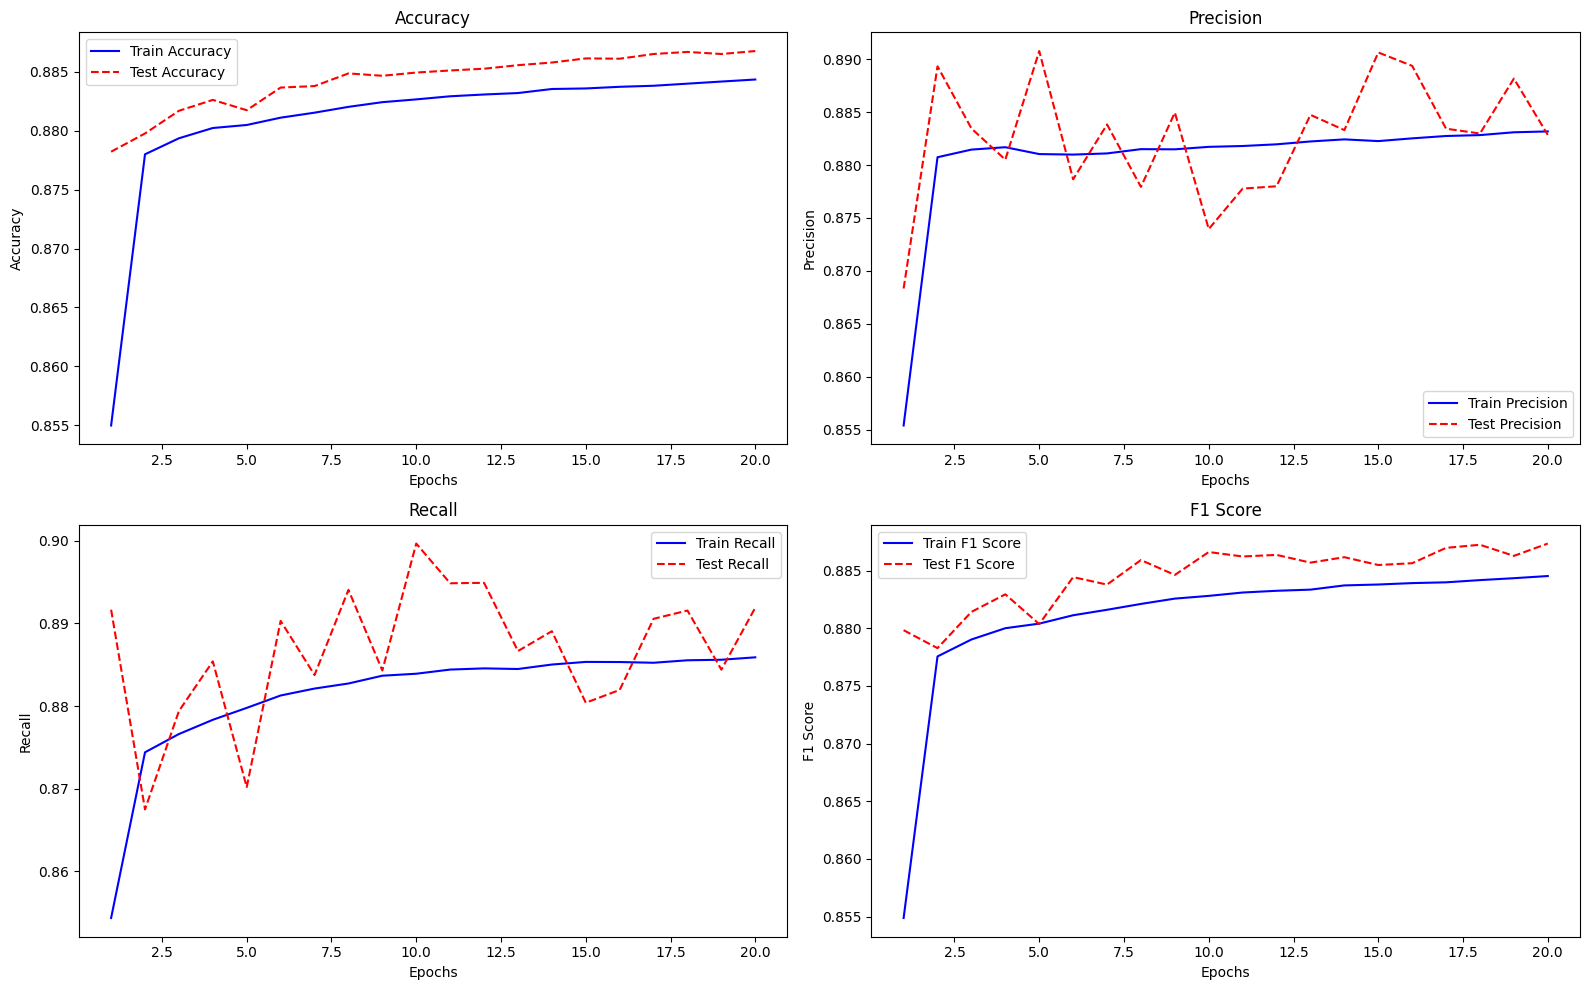

In [40]:

# Plot Metrics for Training and Testing
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(16, 10))


# Save the trained HAN model
torch.save(model.state_dict(), "han_model.pt")
print("Model saved successfully as 'han_model.pt'")


# Accuracy Plot
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_acc_history, 'b-', label="Train Accuracy")
plt.plot(epochs_range, test_acc_history, 'r--', label="Test Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Precision Plot
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_prec_history, 'b-', label="Train Precision")
plt.plot(epochs_range, test_prec_history, 'r--', label="Test Precision")
plt.title("Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()

# Recall Plot
plt.subplot(2, 2, 3)
plt.plot(epochs_range, train_rec_history, 'b-', label="Train Recall")
plt.plot(epochs_range, test_rec_history, 'r--', label="Test Recall")
plt.title("Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()

# F1 Score Plot
plt.subplot(2, 2, 4)
plt.plot(epochs_range, train_f1_history, 'b-', label="Train F1 Score")
plt.plot(epochs_range, test_f1_history, 'r--', label="Test F1 Score")
plt.title("F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

In [41]:
print("Final Training Metrics:")
print(f"Train Accuracy: {train_acc_history[-1]:.4f}")
print(f"Train Precision: {train_prec_history[-1]:.4f}")
print(f"Train Recall: {train_rec_history[-1]:.4f}")
print(f"Train F1 Score: {train_f1_history[-1]:.4f}")

print("\nFinal Testing Metrics:")
print(f"Test Accuracy: {test_acc_history[-1]:.4f}")
print(f"Test Precision: {test_prec_history[-1]:.4f}")
print(f"Test Recall: {test_rec_history[-1]:.4f}")
print(f"Test F1 Score: {test_f1_history[-1]:.4f}")


Final Training Metrics:
Train Accuracy: 0.8844
Train Precision: 0.8832
Train Recall: 0.8859
Train F1 Score: 0.8845

Final Testing Metrics:
Test Accuracy: 0.8868
Test Precision: 0.8829
Test Recall: 0.8919
Test F1 Score: 0.8874
